In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from collections import Counter

In [3]:
df = pd.read_table("../data/Aminer/AP_train.tsv", 
                   sep = "\t+", index_col = 0, engine = 'python')

In [4]:
# save to pickle for faster loading in future
df.to_pickle("../data/Aminer/AP_train.pickle")

In [2]:
dfo = pd.read_pickle("../data/Aminer/AP_train.pickle")

In [3]:
n_rows = dfo.shape[0]
n_rows

1976815

In [4]:
def sub(w):
    if w == 0:
        tdf = dfo
        tnr = n_rows
    else:
        tdf = dfo[:w]
        tnr = w
    return tdf, tnr

# 1a

In [71]:
df = sub(0)

In [72]:
authors = [author.split(';') for author in df[df['authors'].notnull()]['authors']]

In [73]:
n_authors = len(set([name for author in authors for name in author]))

In [74]:
n_venues = len(set(df['venue']))

In [75]:
n_pubs = df[['title', 'authors', 'year', 'venue']].drop_duplicates().shape[0]

In [76]:
references = [ref.split(',') for ref in df[df['refs'].notnull()]['refs']]

In [77]:
n_refs = len(set([ref for reference in references for ref in reference]))

In [78]:
print("Total distinct authors:\t", n_authors)
print("Total distinct venues:\t", n_venues)
print("Total publications:\t", n_pubs)
print("Total citations:\t", n_refs)

Total distinct authors:	 1483290
Total distinct venues:	 255808
Total publications:	 1964961
Total citations:	 871089


# 1b

In [165]:
df = sub(10)

In [156]:
venue_not_null = df[df['venue'].notnull()]

In [ ]:
venue_not_null[venue_not_null['venue'].str.contains('Principles and Practice of Knowledge Discovery in Databases')]

# 1c

In [106]:
batch_size = 10000

In [117]:
df, rows = sub(0)

In [118]:
rows

1976815

In [119]:
auth_counter = Counter()

In [120]:
def count_authors(batch):
    #print(len(batch))
    global auth_counter
    for author in batch.str.split(';', expand=True).stack().values:
        auth_counter[author] += 1

In [121]:
for i in range(rows//batch_size + 1):
    start_index = batch_size * i
    end_index = batch_size * (i + 1)
    #print(start_index, end_index)
    count_authors(df['authors'][start_index:end_index])

In [122]:
len(auth_counter)

1483290

In [142]:
counts = np.array(list(auth_counter.values()))

(array([  1.11540400e+06,   1.64361000e+05,   1.03145000e+05,
          5.64970000e+04,   2.69760000e+04,   1.20030000e+04,
          3.92800000e+03,   8.34000000e+02,   1.27000000e+02,
          1.50000000e+01]),
 array([ 0.        ,  0.30236639,  0.60473278,  0.90709918,  1.20946557,
         1.51183196,  1.81419835,  2.11656474,  2.41893113,  2.72129753,
         3.02366392]),
 <a list of 10 Patch objects>)

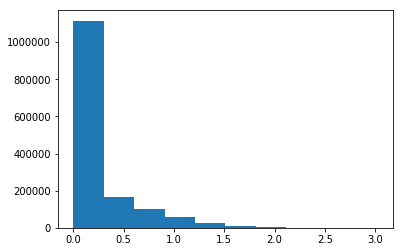

In [138]:
plt.hist(np.log10(list(auth_counter.values())))

# 1d

In [158]:
def print_summary(values, string):
    print(string, ": ", sep='')
    print("Mean: ", np.mean(values), sep="\t\t\t")
    print("1st quantile: ", np.percentile(values, 25), sep="\t\t")
    print("Median/2nd quantile: ", np.median(values), sep="\t")
    print("3st quantile: ", np.percentile(values, 75), sep="\t\t")
    print("Standard deviation: ", np.std(values), sep="\t")

In [159]:
print_summary(counts, "Number of publications per author:")

Number of publications per author:: 
Mean: 			3.28167586918
1st quantile: 		1.0
Median/2nd quantile: 	1.0
3st quantile: 		2.0
Standard deviation: 	8.83637959265


The mean and median are 

# 1e

In [160]:
pub_counter = Counter()

In [172]:
df, rows = sub(0)

In [174]:
publication_counts = df['venue'].value_counts()

In [177]:
print_summary(publication_counts, "Number of publications pper venue:")

Number of publications pper venue:: 
Mean: 			7.7309658368695855
1st quantile: 		1.0
Median/2nd quantile: 	1.0
3st quantile: 		1.0
Standard deviation: 	83.3809075405714


In [185]:
print("Venue with maximum publications: ", publication_counts.idxmax())

Venue with maximum publications:  IEEE Transactions on Information Theory


# 1f 

Number of references

In [145]:
non_null_refs = df[df['refs'].notnull()]

In [127]:
ref_counts = non_null_refs['refs'].str.count(',') + 1

(array([ 214.,    5.,    3.,    2.,    2.,    2.,    1.,    2.,    2.,    2.]),
 array([  1.00000000e+00,   7.29910000e+03,   1.45972000e+04,
          2.18953000e+04,   2.91934000e+04,   3.64915000e+04,
          4.37896000e+04,   5.10877000e+04,   5.83858000e+04,
          6.56839000e+04,   7.29820000e+04]),
 <a list of 10 Patch objects>)

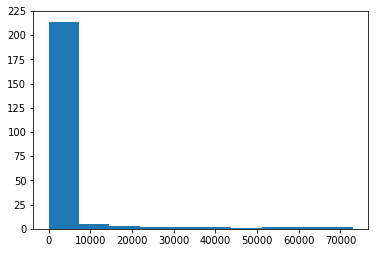

In [68]:
plt.hist(ref_counts.value_counts())

In [146]:
non_null_refs.loc[ref_counts.idxmax()]

title                                       Cited References
authors    Johannes Grabmeier;Erich Kaltofen;Volker Weisp...
year                                                    2003
venue                              Computer algebra handbook
refs       293,767,858,1363,1460,1807,1825,2172,2593,2835...
abs                                                      NaN
Name: 719353, dtype: object

This makes sense, as the paper seems to be just a list of publications

Number of citations

In [26]:
df, rows = sub(0)

In [32]:
def count_citations(batch):
    global citation_counter
    for reference in batch.str.split(',', expand=True).stack().values:
        citation_counter[reference] += 1

In [64]:
citation_counter = Counter()
batch_size = 10000
for i in range(rows//batch_size + 1):
    start_index = batch_size * i
    end_index = batch_size * (i + 1)
    count_citations(non_null_refs['refs'][start_index:end_index])

In [149]:
df.iloc[int(citation_counter.most_common()[0][0])]

title      Fuzzy Switching and Automata: Theory and Appli...
authors                         Abraham Kandel;Samuel C. Lee
year                                                    1979
venue      Fuzzy Switching and Automata: Theory and Appli...
refs                                                     NaN
abs                                                      NaN
Name: 408398, dtype: object

This is a very old paper, 1979, makes sense that it has the most references.

# 1g

In [153]:
citations_per_venue_counter = Counter()
def citations_per_venue():
    return